In [1]:
import itertools
import logging
import time
import numpy as np
import math
import scipy.special
import pandas as pd
import seaborn as sns

from qiskit.circuit.library import EfficientSU2
from qiskit import Aer
# from qiskit.validation.base import BaseModel, BaseSchema, ObjSchema, bind_schema, Obj
from qiskit.aqua import QuantumInstance
# from qiskit.aqua.operators import Z2Symmetries, WeightedPauliOperator
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
# from qiskit.aqua.components.optimizers import COBYLA
from qiskit.chemistry.fermionic_operator import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from pyscf import gto, scf, ao2mo, fci, cc, mp, hci
from pyscf.hci import SelectedCI 
from pyscf.fci import cistring
import numpy as np
import itertools
from collections import Counter
import operator
import matplotlib.pyplot as plt
import pyscf
import h5py

In [2]:
def convert_t2_exc_indices_to_occ_virt_ind(inds, nelec, norb):
    # converts indices of double block excitations alpha, beta
    # to indices as occ, occ, virt, virt
    
    conv_inds = np.zeros((4), dtype=int)
    nocc = int(nelec/2)
#     print("inds =", inds)
    conv_list = list()
    for n in range(4):
        if inds[n] < nocc:
            conv_inds[n] = int(inds[n])

        if nocc <= inds[n] < norb:
            conv_inds[n] = int(inds[n] - nocc)
        
        if norb <= inds[n] < norb + nocc:
            conv_inds[n] = int(inds[n] - norb)
        
        if norb + nocc <= inds[n] < 2*norb:
            conv_inds[n] = int(inds[n] - norb - nocc)
        conv_list.append(conv_inds[n]) 
    
#     print("converted inds", conv_list)
    
    return list(conv_list)

def convert_t1_exc_indices_to_occ_virt_ind(inds, nelec, norb):
    # converts indices of single block excitations alpha, beta
    # to indices as occ, virt
    
    conv_inds = np.zeros((2), dtype=int)
    nocc = int(nelec/2)
#     print("inds =", inds)
    conv_list = list()
    for n in range(2):
        if inds[n] < nocc:
            conv_inds[n] = int(inds[n])

        if nocc <= inds[n] < norb:
            conv_inds[n] = int(inds[n] - nocc)
        
        if norb <= inds[n] < norb + nocc:
            conv_inds[n] = int(inds[n] - norb)
        
        if norb + nocc <= inds[n] < 2*norb:
            conv_inds[n] = int(inds[n] - norb - nocc)
        conv_list.append(conv_inds[n]) 
    
#     print("converted inds", conv_list)
    
    return list(conv_list)

    
def generate_t2_indices(norb, nelec, occ=None, t2=None):
    """
    Based on number of spatial orbitals and electrons generates: 
    1) Double excitations indices in block format i->a, j->b
    2) Dictionary where keys are spin-orbitals occupation numbers (determinants), values are indices from 1)
    
    By default uses RHF configuration
    norb: number of spatial orbitals, half the number of spin orbitals
    nelec: total number of electrons
    occ: occupation numbers for spin orbitals in block format (all alpha, all beta)
    """

    amp_dict = dict()
    if occ is None:
        occ = np.zeros(norb*2, dtype=int)
        for n in range(int(nelec/2)):
            occ[n] = 1
            occ[n + norb] = 1
    
    # Indices for excitations from occupied to unoccupied
    i_inds = [i_ind for i_ind, element in enumerate(occ[0:norb]) if element > 0]
    j_inds = [j_ind + norb for j_ind, element in enumerate(occ[norb:]) if element > 0]
    a_inds = [a_ind for a_ind, element in enumerate(occ[0:norb]) if element == 0]
    b_inds = [b_ind + norb for b_ind, element in enumerate(occ[norb:]) if element == 0]

    inds = []
    t2_amp_vs_det_dict = dict()
    for exc_from_i in i_inds:
        for exc_from_j in j_inds:
            for exc_to_a in a_inds:
                for exc_to_b in b_inds:
                    
                    if exc_to_a > exc_from_i and exc_to_b > exc_from_j: # exciting only up, no deexcitation
                        # Maybe we can allow de-excitation here?
                        # computing new occupation numbers
                        fin_occ = occ.copy()
                        fin_occ[exc_from_i] -= 1
                        fin_occ[exc_to_a] += 1
                        fin_occ[exc_from_j] -= 1
                        fin_occ[exc_to_b] += 1

                        # appending array with proper indices and dictionary with occ numbers and indices
                        ind = [exc_from_i, exc_to_a, exc_from_j, exc_to_b]
                        inds.append(ind)
                        conf_string = "".join([str(occ_n) for occ_n in fin_occ])
                        if conf_string in t2_amp_vs_det_dict:
                            print("ABORT!!!!!!!!!!!!!!!!!")
#                         print(conf_string[:norb], conf_string[norb:], ind)
#                         if conf_string in t2_amp_vs_det_dict:
#                             print("already exists (alpha beta)")
#                             t2_amp_vs_det_dict[conf_string].append(ind)
#                         else:
                        t2_amp_vs_det_dict[conf_string] = ind
                        if t2 is not None:
                            amp_dict[conf_string] = t2[exc_from_i, exc_from_j - norb,
                                                       exc_to_a - int(nelec/2),
                                                       exc_to_b - int(nelec/2) - norb]
#                         print(t2_amp_vs_det_dict[conf_string])
                    else:
                        continue
    
    # excitations from both alpha 
    
    pair_inds_i = []
    for i in i_inds:
        for j in i_inds:
            if i != j:
                pair_inds_i.append((i, j))
    
    pair_inds_a = []
    for a in a_inds:
        for b in a_inds:
            if a != b:
                pair_inds_a.append((a, b))
    
#     print("pair inds i", pair_inds_i)
#     print("pair inds a", pair_inds_a)
    for exc_from_i, exc_from_j in pair_inds_i:
        for exc_to_a, exc_to_b in pair_inds_a:
#             print("ijab", exc_from_i, exc_from_j, exc_to_a, exc_to_b)
            if exc_to_a > exc_from_i and exc_to_b > exc_from_j: # exciting only up, no deexcitation
                # Maybe we can allow de-excitation here?
                # computing new occupation numbers
                fin_occ = occ.copy()
                fin_occ[exc_from_i] -= 1
                fin_occ[exc_to_a] += 1
                fin_occ[exc_from_j] -= 1
                fin_occ[exc_to_b] += 1

                # appending array with proper indices and dictionary with occ numbers and indices
                ind = [exc_from_i, exc_to_a, exc_from_j, exc_to_b]
                inds.append(ind)
                conf_string = "".join([str(occ_n) for occ_n in fin_occ])
#                 print("conf_string", conf_string, "ind", ind)
                if conf_string in t2_amp_vs_det_dict:
#                     print("\nalready exists (alpha alpha)")
#                     t2_amp_vs_det_dict[conf_string].append(ind)
                      pass
                else:
                    t2_amp_vs_det_dict[conf_string] = ind
                
                if t2 is not None:
                    print(conf_string[:norb], conf_string[norb:])
                    #!!!!!! for now keeping largest amplitude
                    conv_inds = convert_t2_exc_indices_to_occ_virt_ind([exc_from_i, exc_from_j,
                                                                        exc_to_a, exc_to_b], nelec, norb)
                    print("new t2 alpha",  
                        t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]])
                    if conf_string in amp_dict:
                        print("old t2", amp_dict[conf_string])
                        # trying to keep smaller ones
                        if np.abs(amp_dict[conf_string]) > t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]:
                            print("keeping old")
                            pass
                        else:
                            print("keeping new")
                            amp_dict[conf_string] = t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]
                        
                    else:
                        print("keeping new")
                        amp_dict[conf_string] = t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]

            else:
                continue
                
                
        # NOT SURE if this makes any sense, since alpha and beta are only conventions
#     excitations from both beta 
        
    pair_inds_j = []
    for i in j_inds:
        for j in j_inds:
            if i != j:
                pair_inds_j.append((i, j))
    
    pair_inds_b = []
    for a in b_inds:
        for b in b_inds:
            if a != b:
                pair_inds_b.append((a, b))

    for exc_from_i, exc_from_j in pair_inds_j:
        for exc_to_a, exc_to_b in pair_inds_b:
#             print("ijab", exc_from_i, exc_from_j, exc_to_a, exc_to_b)
            if exc_to_a > exc_from_i and exc_to_b > exc_from_j: # exciting only up, no deexcitation
                # Maybe we can allow de-excitation here?
                # computing new occupation numbers
                fin_occ = occ.copy()
                fin_occ[exc_from_i] -= 1
                fin_occ[exc_to_a] += 1
                fin_occ[exc_from_j] -= 1
                fin_occ[exc_to_b] += 1

                # appending array with proper indices and dictionary with occ numbers and indices
                ind = [exc_from_i, exc_to_a, exc_from_j, exc_to_b]
                inds.append(ind)
                conf_string = "".join([str(occ_n) for occ_n in fin_occ])
                
                # !!!! The following is problematic, different amplitudes corresponding to the same 
                # determinant have different magnitudes!
                if conf_string in t2_amp_vs_det_dict:
#                     print("already exists (beta beta)")
#                     t2_amp_vs_det_dict[conf_string].append(ind)
                    pass
                else:
                    t2_amp_vs_det_dict[conf_string] = ind

                if t2 is not None:
                    #!!!!!! for now keeping largest amplitude
                    print(conf_string[:norb], conf_string[norb:])
                    conv_inds = convert_t2_exc_indices_to_occ_virt_ind([exc_from_i, exc_from_j,
                                                                        exc_to_a, exc_to_b], nelec, norb)
                    print("new t2 beta",  
                        t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]])
                    if conf_string in amp_dict:
                        print("old t2", amp_dict[conf_string])
                        # trying to keep smaller ones
                        if np.abs(amp_dict[conf_string]) > t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]:
                            print("keeping old")
                            pass
                        else:
                            print("keeping new")
                            amp_dict[conf_string] = t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]
                        
                    else:
                        print("keeping new")
                        amp_dict[conf_string] = t2[conv_inds[0], conv_inds[1], conv_inds[2], conv_inds[3]]

            else:
                continue

    
    return inds, t2_amp_vs_det_dict, amp_dict

def generate_t1_indices(norb, nelec, occ=None, t1=None):
    """
    Generates: 
    1) Single excitations indices in block format i->a, j->b
    2) Dictionary where keys are spin-orbitals occupation numbers (determinants), values are indices from 1)
    
    By default uses RHF configuration
    norb: number of spatial orbitals, half the number of spin orbitals
    nelec: total number of electrons
    occ: occupation numbers for spin orbitals in block format (all alpha, all beta)
    """
    
    if occ is None:
        occ = np.zeros(norb*2, dtype=int)
        for n in range(int(nelec/2)):
            occ[n] = 1
            occ[n + norb] = 1
    inds = []
    amp_vs_det_dict = dict()
    amp_dict = dict()
    
    i_inds = [i_ind for i_ind, element in enumerate(occ[0:norb]) if element > 0]
    j_inds = [j_ind + norb for j_ind, element in enumerate(occ[norb:]) if element > 0]
    a_inds = [a_ind for a_ind, element in enumerate(occ[0:norb]) if element == 0]
    b_inds = [b_ind + norb for b_ind, element in enumerate(occ[norb:]) if element == 0]
    
    # single excitations for alpha orbitals
    for exc_from_i in i_inds:
        for exc_to_a in a_inds:
            ini_occ = occ.copy()
            
            if exc_to_a > exc_from_i:
                ini_occ = occ.copy()
                ini_occ[exc_from_i] -= 1
                ini_occ[exc_to_a] += 1
                inds.append([exc_from_i, exc_to_a])
                string1 = "".join([str(a) for a in ini_occ])
                amp_vs_det_dict[string1] = [exc_from_i, exc_to_a]
                if t1 is not None:
                    amp_dict[string1] = t1[exc_from_i, exc_to_a - int(nelec/2)]
                    
    # single excitations for beta orbitals
    for exc_from_j in j_inds:
        for exc_to_b in b_inds:
            
            if exc_to_b > exc_from_j:
                ini_occ = occ.copy()
                ini_occ[exc_from_j] -= 1
                ini_occ[exc_to_b] += 1
                inds.append([exc_from_j, exc_to_b])
                string2 = "".join([str(a) for a in ini_occ])
                amp_vs_det_dict[string2] = [exc_from_j, exc_to_b]
                if t1 is not None:
                    amp_dict[string2] = t1[exc_from_j - norb, exc_to_b - int(nelec/2) - norb]
            

    return inds, amp_vs_det_dict, amp_dict


In [3]:
# logging.basicConfig(level=logging.DEBUG)
K = 12
N = 4
total = 0
for n in range(1, N+1):
    total += scipy.special.comb(N, n)*scipy.special.comb(K-N, n)
    print("N configurations", scipy.special.comb(N, n)*scipy.special.comb(K-N, n))
print("total", total)
print(scipy.special.comb(K, N))

N configurations 32.0
N configurations 168.0
N configurations 224.0
N configurations 70.0
total 494.0
495.0


In [4]:
def create_array_for_heatmap(det_vs_amp_dict):
    
    norb = len(list(det_vs_amp_dict.keys())[0])
    nelec = sum([int(a) for a in list(det_vs_amp_dict.keys())[0]])        
    n_occ = int(nelec/2)
    n_sp_orb = int(norb/2)
    
    alpha = []
    beta = []
    coeff = []
    
    for key in det_vs_amp_dict.keys():
        alpha.append(key[0:n_sp_orb])
        beta.append(key[n_sp_orb:])
        coeff.append(det_vs_amp_dict[key])

    return alpha, beta, coeff
        
def filter_out_n_order_exc_dets(det_vs_amp_dict, n):
    
    filtered_dets = []
    norb = len(list(det_vs_amp_dict.keys())[0])
    nelec = sum([int(a) for a in list(det_vs_amp_dict.keys())[0]])
    filtered_dets = dict()

#     print("norb", norb)
#     print("nelec", nelec)
    n_occ = int(nelec/2)
    n_sp_orb = int(norb/2)
    for key in det_vs_amp_dict.keys():
        exc_n_a = sum([int(a) for a in key[0:n_occ]])
        exc_n_b = sum([int(a) for a in key[n_sp_orb:n_sp_orb + n_occ]])
        
        exc = nelec - exc_n_a - exc_n_b
        if exc == n:
            filtered_dets[key] = det_vs_amp_dict[key].copy()
    
    return filtered_dets  

def compute_miltiplicity(det):
    # compute multiplicity for a determinant (block form)
    # accepts string with first half alpha, second half beta
    n_orb = int(len(det)/2)
    if n_orb % 2 != 0: print("Not a valid string")
    spin = 0
    for n in range(n_orb):
        spin += 1/2 * int(det[n])
        spin -= 1/2 * int(det[n + n_orb])
    mult = int(2 * spin + 1)
    return mult

def print_sorted_dict(dict_to_print):
    norb = int(len(list(dict_to_print.keys())[0]) / 2)
    sorted_dict = dict( sorted(dict_to_print.items(), key=lambda kv: np.max(np.abs(kv[1])), reverse=True))
    for key in sorted_dict.keys():
        print(key[0:norb], key[norb:], sorted_dict[key])

def filter_dets_from_dict(d, thresh=1e-08):
    filtered_dict = dict()
    for key in d.keys():
        if np.max(np.abs(d[key])) > thresh:

            filtered_dict[key] = d[key]
        # else:
        #     print(key, np.max(np.abs(d[key])))
    # print("filtered", filtered_dict)
    return filtered_dict  

def filter_out_excitations_from_det_dict(dict_to_filter, order_of_exc, nelec):
    filtered_dict = dict()
    nocc = int(nelec/2)
    for key in dict_to_filter.keys():
        n_el_occ = 0
        for x in key[0:nocc]:
            n_el_occ += int(x)
        # print("n_el_occ", n_el_occ, key)
        if nelec - n_el_occ == order_of_exc:
            filtered_dict[key] = dict_to_filter[key]
    return filtered_dict


    return det_vs_amp_ind_dict

def run_calcs(r, mol, basis, sci_select_cutoff, sci_ci_coeff_cutoff, det_thresh, discarded_amp_thresh, mp2_thresh):
   
    print("r=", r)
    basis = basis
    sci_select_cutoff = sci_select_cutoff
    sci_ci_coeff_cutoff = sci_ci_coeff_cutoff
    det_thresh = det_thresh # filters SCI selected dets (in FCI format there's a lot of zeros)
    discarded_amp_thresh = discarded_amp_thresh # for counting amplitudes filtered out by SCI
    mp2_thresh = mp2_thresh # throw out mp amps smaller than this 

    mol.verbose = 0

    # RHF
    mf = scf.RHF(mol)
#     mf = scf.UHF(mol)
    e_hf = mf.kernel()
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    eri = ao2mo.kernel(mol, mf.mo_coeff)
    
    
    # Full CI
    print("\nFCI")
    cisolver = fci.FCI(mol)

    e_fci, ci = cisolver.kernel(h1, eri, h1.shape[1], mol.nelec, ecore=mol.energy_nuc())
#     e_fci, ci = cisolver.kernel(ecore=mol.energy_nuc())
    
    print("FCI energy", e_fci)
    norb = h1.shape[1]
    nelec = mol.nelectron
    print("nelec", nelec)
    print("norb", norb)
#     print("Num Strings: ", cistring.num_strings(norb,nelec/2))
    print("Spin contamination in FCI:\nS^2", cisolver.spin_square(ci, norb, nelec=(int(nelec/2), int(nelec/2))))
    
    spin_orb_strings = list()
    det_dict = dict()
    det_dict_spin_orb = dict()
    
    for alpha_addr in range(ci.shape[0]):
        for beta_addr in range(ci.shape[0]):
            # In pyscf the lower energy orbitals are to the RIGHT!!! so we have to reverse the strings

            a_str = bin(cistring.addrs2str(norb, int(nelec/2),[alpha_addr])[0])[2:].rjust(norb, '0')[::-1] # converting to strings with occ numbers
            b_str = bin(cistring.addrs2str(norb, int(nelec/2),[beta_addr])[0])[2:].rjust(norb, '0')[::-1]
            
            spin_orb_str = ''
            spin_orb_str = a_str + b_str
            
            # for spin orbitals
            det_dict_spin_orb[spin_orb_str] = [ci[alpha_addr, beta_addr]]
            
    print("Number of FCI determinants", len(det_dict_spin_orb.keys()))

    # Running CCSD
    print("\nCCSD")
    mycc = cc.CCSD(mf)
    result = mycc.kernel()
    t2 = result[2]
    t1 = result[1]
    ccsd_conv = result[0]

    t2_inds_ccsd, det_vs_amp_ind, amp_dict = generate_t2_indices(norb, nelec, t2=t2)
    t1_inds_ccsd, det_vs_amp_t1_ind, amp_dict_t1 = generate_t1_indices(norb, nelec, t1=t1)

    print("Number of CCSD t1 dets", len(det_vs_amp_t1_ind.keys()))
    print("Number of CCSD t2 dets", len(det_vs_amp_ind.keys()))
    
    
    # MP2
    print("\nMP2")
    pt = mp.MP2(mf).run()
    mp2 = pt.run()

    t2_inds_mp2, mp2_dict, amp_dict_mp2 = generate_t2_indices(norb, nelec, t2=mp2.t2)

    print("number of MP2 t2 dets", len(mp2_dict.keys()))

    t2_filtered_mp2 = mp2.t2.copy()
    mp2_amps_to_keep = []
    mp2_amp_inds_smaller_than_thresh = []
    for key in mp2_dict.keys():
        
        idx = mp2_dict[key]
#         print(idx)
        if np.abs(amp_dict_mp2[key]) < mp2_thresh:
            conv_idx = convert_t2_exc_indices_to_occ_virt_ind(idx, nelec, norb)
#             print("MP2 t2 shape", np.shape(t2_filtered_mp2))
#             print("IDX", conv_idx)
            # this function spits out ijab order with occ, occ, virt, virt dimensions
            t2_filtered_mp2[conv_idx[0], conv_idx[2], conv_idx[1], conv_idx[3]] = 0
            mp2_amp_inds_smaller_than_thresh.append(idx)
        else:
            mp2_amps_to_keep.append(idx)
#     print("mp2 amps to discard", mp2_amp_inds_smaller_than_thresh)
    zero_mp2_indices = np.abs(mp2.t2) < mp2_thresh
    t2_filtered_mp2 = t2.copy()
    t2_filtered_mp2[zero_mp2_indices] = 0
    
#     #### DEBUG#######
#     # For LiH    
#     tmp1 = convert_t2_exc_indices_to_occ_virt_ind([0,1,2,5], 4, 6)
#     tmp2 = convert_t2_exc_indices_to_occ_virt_ind([0,1,5,2], 4, 6)
#     print(tmp1)
#     print(tmp2)
#     print(np.shape(t2))
#     print(t2[tmp1[0], tmp1[1], tmp1[2], tmp1[3]], t2[tmp2[0], tmp2[1], tmp2[2], tmp2[3]])
#     print(mp2.t2[tmp1[0], tmp1[1], tmp1[2], tmp1[3]],
#           t2[tmp2[0], tmp2[1], tmp2[2], tmp2[3]])
#     #################
    
    
    ################
    # Selected CI
    ###############
    
    print("\nSelected CI")
    sci_solver = hci.SCI(mol)
    sci_solver.select_cutoff = sci_select_cutoff
    sci_solver.ci_coeff_cutoff = sci_ci_coeff_cutoff

    nmo = mf.mo_coeff.shape[1]
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    h2 = ao2mo.full(mol, mf.mo_coeff)
    e_sci, civec = sci_solver.kernel(h1, h2, mf.mo_coeff.shape[1], mol.nelectron, ecore=mol.energy_nuc())
    print("e_sci", e_sci)
    print("Total number of selected CI determinants: {}".format(len(civec[0])))

    # For conversion of SCI to FCI vector for comparison
    neleca = int(nelec/2)
    nelecb = int(nelec/2)

    # Transforming SCI vector to FCI format
    strsa = cistring.gen_strings4orblist(range(norb), neleca)
    stradic = dict(zip(strsa,range(strsa.__len__())))
    strsb = cistring.gen_strings4orblist(range(norb), nelecb)
    strbdic = dict(zip(strsb,range(strsb.__len__())))
    na = len(stradic)
    nb = len(strbdic)
    ndet = len(civec[0])
    fcivec = np.zeros((na,nb))
    for idet, (stra, strb) in enumerate(civec[0]._strs.reshape(ndet,2,-1)):
        ka = stradic[stra[0]]
        kb = strbdic[strb[0]]
        fcivec[ka,kb] = civec[0][idet] # SCI coefficients array in FCI format (with alpha and beta strings) 


    # Obtaining spin orbital occupation numbers for SCI
    det_dict_sci_spin_orb = dict()
    
    for alpha_addr in range(fcivec.shape[0]):
        for beta_addr in range(fcivec.shape[0]):
            # In pyscf the lower energy orbitals are to the RIGHT!!! so we have to reverse the strings
            # converting to strings with occ numbers
            a_str = bin(cistring.addrs2str(norb, int(neleca),[alpha_addr])[0])[2:].rjust(norb, '0')[::-1] 
            b_str = bin(cistring.addrs2str(norb, int(nelecb),[beta_addr])[0])[2:].rjust(norb, '0')[::-1]
            spin_orb_string = a_str + b_str
            det_dict_sci_spin_orb[spin_orb_string] = fcivec[alpha_addr, beta_addr]

    filtered_sci_dets_spin_orb = filter_dets_from_dict(det_dict_sci_spin_orb, det_thresh)        
    print("Number of SCI spin orbitals configurations with CI coefficients > {} is {}".format(det_thresh, len(filtered_sci_dets_spin_orb.keys())))

#     # Filter amps using SCI
    thrown_out_dets = []
    thrown_out_amps = []
    for key in det_dict_sci_spin_orb.keys():
        # loop over all determinants
        if key not in filtered_sci_dets_spin_orb.keys():
            # condition if this determinant was filtered out
            thrown_out_dets.append(key) # this gives us list of dets that were filtered out
            if key in amp_dict.keys():
                thrown_out_amps.append(amp_dict[key]) 
    
    # Creating list of t2 amplitudes to keep after SCI screening
    # matches amps with dets 
    amps_t2_to_keep = []
    n_small_t2_amps_kept = 0
    for key in filtered_sci_dets_spin_orb.keys():
        if key in amp_dict.keys(): # why does this have to be here?
            idx = det_vs_amp_ind[key]
            amps_t2_to_keep.append(idx)
            conv_idx = convert_t2_exc_indices_to_occ_virt_ind(idx, nelec, norb)
#             print("idx = ", idx)
#             print("conv idx", conv_idx)
            if np.abs(t2[conv_idx[0], conv_idx[2], conv_idx[1], conv_idx[3]]) < mp2_thresh:
                n_small_t2_amps_kept +=1
        else:
#             print("KEY {} NOT IN AMP DICT!!!".format(key))
            pass

#     print("t2 amps to keep:", amps_t2_to_keep)

    # Creating list of t1 amplitudes to keep after SCI screening
    # matches amps with dets 
    amps_t1_to_keep = []
    n_small_t1_amps_kept = 0
    t1_filtered = np.zeros(np.shape(t1))
    for key in filtered_sci_dets_spin_orb.keys():
        if key in amp_dict_t1.keys():
            idx = det_vs_amp_t1_ind[key]
            conv_idx = convert_t1_exc_indices_to_occ_virt_ind(idx, nelec, norb)
#             print("idx", idx)
#             print("conv_idx", conv_idx)
            amps_t1_to_keep.append(idx)

            if np.abs(t1[conv_idx[0], conv_idx[1]]) < mp2_thresh:
                n_small_t1_amps_kept +=1 

#     print("t1 amps to keep", amps_t1_to_keep)

    # t1_filtered and t2_filtered indices are not the same format as excitations!
    
    # Creating array for t2 amplitudes where we do prescreening using selected CI
    t2_filtered_sci = np.zeros(np.shape(t2))
    for idx in amps_t2_to_keep:
        conv_idx = convert_t2_exc_indices_to_occ_virt_ind(idx, nelec, norb)
        t2_filtered_sci[conv_idx[0], conv_idx[2], conv_idx[1], conv_idx[3]]\
        = t2[conv_idx[0], conv_idx[2], conv_idx[1], conv_idx[3]]

    # Creating array for t1 amplitudes where we do prescreening using selected CI
    t1_filtered_sci = np.zeros(np.shape(t1))
    for inds in amps_t1_to_keep:
        conv_inds = convert_t1_exc_indices_to_occ_virt_ind(inds, nelec, norb)
        t1_filtered_sci[conv_inds[0], conv_inds[1]] = t1[conv_inds[0], conv_inds[1]]

    # Results to save for analysis

    # CCSD Energies after filtering amplitudes
    e_ccsd_mp2_filter = mycc.energy(t1, t2_filtered_mp2) + e_hf
    e_ccsd_sci_filter = mycc.energy(t1, t2_filtered_sci) + e_hf
#     e_ccsd_sci_filter = mycc.energy(t1_filtered_sci, t2_filtered_sci) + e_hf
    e_ccsd = mycc.energy(t1, t2) + e_hf

    # Errors
    sci_err_wrt_fci = e_sci[0] - e_fci
    ccsd_err_wrt_fci = e_ccsd - e_fci
    err_wrt_ccsd = e_ccsd_sci_filter - e_ccsd
    err_wrt_fci = e_ccsd_sci_filter - e_fci
    err_ccsd_mp2_filter = e_ccsd_mp2_filter - e_fci

    # Amplitudes and determinants
    n_dets_fci = len(det_dict_spin_orb.keys())
    n_dets_sci = len(civec[0])
    n_ccsd_amp = np.shape(t2)[0] * np.shape(t2)[1] * np.shape(t2)[2] * np.shape(t2)[3]
    n_t2_amps_mp2_filter = n_ccsd_amp - len(mp2_amp_inds_smaller_than_thresh)
    n_amps_t2_to_keep = len(amps_t2_to_keep)
    thrown_out_array = np.asarray(thrown_out_amps)
    max_amp_thrown_out = np.max(thrown_out_array)
    n_amps_thrown_out = len(thrown_out_array[thrown_out_array>discarded_amp_thresh])

    print("\nResults:")

    print("{:<40s}{:>30.8e}".format("SCI Error WRT FCI:", sci_err_wrt_fci))
    print("{:<40s}{:>30.8e}".format("CCSD Error WRT FCI:", ccsd_err_wrt_fci))
    print("\n{:<40s}{:>30.8e}".format("Error WRT CCSD due to cutoff, SCI filter:", err_wrt_ccsd))
    print("{:<40s}{:>30.8e}".format("Error WRT FCI due to cutoff, SCI filter:", err_wrt_fci))

    print("\n{:<40s}{:>30.8e}".format("MP2 cutoff threshold", mp2_thresh))
    print("{:<40s}{:>30.8e}".format("Error of CCSD WRT FCI, MP2 cutoff ", err_ccsd_mp2_filter))
    print("{:<40s}{:>29d}".format("Number of CCSD t2 amplitudes, MP2 filter:", n_t2_amps_mp2_filter))


    print("\n{:<40s}{:>30d}".format("Total number of FCI determinants:", n_dets_fci))
    print("{:<40s}{:>30d}".format("Total number of SCI determinants:", n_dets_sci))
    print("\n{:<40s}{:>30d}".format("Number of CCSD t2 amplitudes", n_ccsd_amp))
    print("{:<40s}{:>30d}".format("Number of t2 amplitudes screened by SCI:", n_amps_t2_to_keep))
    print("{:<30s}{:<2.2e}:{:>21d}".format("Number of kept amplitudes smaller than ", discarded_amp_thresh, n_small_t2_amps_kept))
    print("{:<40s}{:<2.2e} thrown out:{:>10d}".format("Number of amplitudes larger than", discarded_amp_thresh,
        n_amps_thrown_out))
    print("\n{:<40s}{:>30.8e}".format("Largest discarded amplitude:", max_amp_thrown_out))
    
    return amps_t2_to_keep, mp2_amps_to_keep, det_dict_spin_orb, filtered_sci_dets_spin_orb, norb, amp_dict, amp_dict_t1, t2

In [5]:
r = 1.5
basis = 'sto-3g'

# For H2O molecule
theta = 104.5
c,s = np.cos(np.radians(theta)), np.sin(np.radians(theta))
R = np.array(((c, -s), (s, c))) #Rotation matrix
x,y = R @ np.array((0, r))

atom='O .0 .0 .0; H .0 .0 {}; H .0 {} {}'.format(r, x, y)
# atom = 'Be .0 .0 .0; H .0 .0 {}; H .0 .0 {}'.format(r, -r)
# atom = 'H 0 0 0; H 0 0 {}; H 0 0 {}; H 0 0 {}'.format(r, r*2, r*3)
# atom='Li 0 0 0; H 0 0 {}'.format(r)
# atom='N 0 0 0; N 0 0 {}'.format(r)
# atom='H 0 0 0; H 0 0 {}; H 0 0 {}; H 0 0 {}; H 0 0 {}; H 0 0 {}'.format(r, r*2, r*3, r*4, r*5)

# For UCCSD calculations
driver = PySCFDriver(atom=atom, unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis=basis)
molecule = driver.run()
# e_nr = molecule.nuclear_repulsion_energy
# core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.JORDAN_WIGNER,
#                    two_qubit_reduction=False, freeze_core=False)
# qubit_op, aux_ops = core.run(molecule)
# print("UCCSD requires {} qubits".format(qubit_op.num_qubits))


# For pure PySCF calculations
mol = gto.M(atom=atom, basis=basis)
# norb_spatial = int(qubit_op.num_qubits/2)
nelec = molecule.num_alpha + molecule.num_beta

sci_select_cutoff = .0001
sci_ci_coeff_cutoff = .001
det_thresh = 1e-15 # filters SCI selected dets (in FCI format there's a lot of zeros)
discarded_amp_thresh = 1e-06 # for counting amplitudes filtered out by SCI
mp2_thresh = 1e-6 # throw out mp amps smaller than this 

# Running PySCF calculations for filtering amplitudes
t2_sci_filtered, t2_mp2_filtered, det_dict_spin_orb, filtered_sci_dets_spin_orb, norb_spatial, amp_dict_t2, amp_dict_t1, t2_ccsd\
= run_calcs(r, mol, basis, sci_select_cutoff, sci_ci_coeff_cutoff, det_thresh, discarded_amp_thresh, mp2_thresh)

r= 1.5

FCI
FCI energy -74.87343608825451
nelec 10
norb 7
Spin contamination in FCI:
S^2 (3.446431735522163e-12, 1.0000000000068927)
Number of FCI determinants 441

CCSD
0011111 1111100
new t2 alpha 4.2410772819529846e-19
keeping new
0011111 1111100
new t2 alpha 3.973728169351187e-19
old t2 4.2410772819529846e-19
keeping old
0101111 1111100
new t2 alpha -2.1423146165338547e-06
keeping new
0101111 1111100
new t2 alpha 0.00019419914869941846
old t2 -2.1423146165338547e-06
keeping new
0110111 1111100
new t2 alpha -3.23878807654415e-20
keeping new
0110111 1111100
new t2 alpha 2.6963553602526022e-18
old t2 -3.23878807654415e-20
keeping new
0111011 1111100
new t2 alpha -1.636316979423323e-18
keeping new
0111011 1111100
new t2 alpha -4.4950898295691224e-18
old t2 -1.636316979423323e-18
keeping old
0011111 1111100
new t2 alpha 3.973728169351187e-19
old t2 4.2410772819529846e-19
keeping old
0011111 1111100
new t2 alpha 4.2410772819529846e-19
old t2 4.2410772819529846e-19
keeping new
1001111 111

In [71]:
# Inspecting the 2e integrals array
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
print("shape of 2e- integrals array:", np.shape(h2))
amp_thresh = 5e-6
ci_thresh = 1e-5

shape of 2e- integrals array: (14, 14, 14, 14)


# Singles

In [72]:
configs = set()
t1_configs = set()
# Filtering t1 amplitudes
t1_inds, t1_amp_vs_det_dict, _ = generate_t1_indices(norb_spatial, nelec)
fci_singles_dict = filter_out_n_order_exc_dets(det_dict_spin_orb, 1)
filtered_fci_singles_dict = filter_dets_from_dict(fci_singles_dict, thresh=ci_thresh)

sci_singles_dict = filter_out_n_order_exc_dets(filtered_sci_dets_spin_orb, 1)

filtered_t1 = []
filtered_t1_amps = []
for t1 in t1_inds:
    if np.abs(h1[t1[0], t1[1]]) > amp_thresh:
        filtered_t1.append(t1)
        filtered_t1_amps.append(h1[t1[0], t1[1]])

for key in t1_amp_vs_det_dict.keys():
    configs.add(key)
#     print(key[0:norb_spatial], key[norb_spatial:],
#           t1_amp_vs_det_dict[key],
#           h1[t1_amp_vs_det_dict[key][0], t1_amp_vs_det_dict[key][1]],
#           )
#     if np.abs(h1[t1_amp_vs_det_dict[key][0], t1_amp_vs_det_dict[key][1]]) > amp_thresh:
    # TEST: multiplying integrals by amplitudes
    if np.abs(h1[t1_amp_vs_det_dict[key][0], t1_amp_vs_det_dict[key][1]] * amp_dict_t1[key]) > amp_thresh:
        t1_configs.add(key)
# print("Total number of configurations:", len(configs))
print("\nNumber of singles in FCI:", len(fci_singles_dict.keys()))
print("Number of significant singles in FCI:", len(filtered_fci_singles_dict.keys()))

print("\nSignificant singly excited configurations", len(t1_configs))
print("Number of singles in SCI:", len(sci_singles_dict.keys()))
print("Matching significant configurations with SCI", len(set(sci_singles_dict.keys()).intersection(t1_configs)))
# print(t1_amp_vs_det_dict.keys())
# print("\n", t1_amp_dict)


Number of singles in FCI: 20
Number of significant singles in FCI: 8

Significant singly excited configurations 8
Number of singles in SCI: 8
Matching significant configurations with SCI 8


The following computations require the integrals stored in the '*chemist*' notation

            h2(i,j,k,l) --> adag_i adag_k a_l a_j

       and the integral values are used for the coefficients of the second-quantized
       Hamiltonian that is built. The integrals input here should be in block spin
       format and also have indexes reordered as follows 'ijkl->ljik'""""

# Doubles

In [73]:
# Filtering amplitudes which are connected by 2-electron integrals elements larger than threshold
t2_inds, t2_amp_vs_det_dict, _ = generate_t2_indices(norb_spatial, nelec)
filtered_t2_amp_vs_det_dict = filter_out_n_order_exc_dets(t2_amp_vs_det_dict, 2)

fci_doubles_dict = filter_out_n_order_exc_dets(det_dict_spin_orb, 2)
filtered_fci_doubles_dict = filter_dets_from_dict(fci_doubles_dict, thresh=ci_thresh)

sci_doubles_dict = filter_out_n_order_exc_dets(filtered_sci_dets_spin_orb, 2)
filtered_sci_doubles_dict = filter_dets_from_dict(fci_doubles_dict, thresh=ci_thresh)


t2_configs = set()

contrib_coeff_doubles_dict_2e = dict()
two_el_doubles = dict()
for key in filtered_t2_amp_vs_det_dict.keys():
    configs.add(key)
    t2_ind = t2_amp_vs_det_dict[key]
    
    if np.abs(h2[t2_ind[3], t2_ind[1], t2_ind[0], t2_ind[2]]) > amp_thresh:
        conv_inds = convert_t2_exc_indices_to_occ_virt_ind([t2_ind[0], t2_ind[2],
                                                            t2_ind[1], t2_ind[3]],
                                                            nelec, norb_spatial)
        contrib_coeff_doubles_dict_2e[key] = t2_ccsd[conv_inds[0], conv_inds[1],
                                                     conv_inds[2], conv_inds[3]]
        two_el_doubles[key] = h2[t2_ind[3], t2_ind[1], t2_ind[0], t2_ind[2]]
        t2_configs.add(key)


print("Total number of doubles in FCI:", len(fci_doubles_dict.keys()))
print("Number of significant doubles in FCI:", len(filtered_fci_doubles_dict.keys()))

fci_intersecting_set = set(filtered_fci_doubles_dict.keys()).intersection(t2_configs)
fci_difference_set = set(filtered_fci_doubles_dict.keys()).symmetric_difference(t2_configs)
print("Matching significant configurations with FCI", len(fci_intersecting_set))
print("Configurations that are in FCI but not in 2e scr", fci_difference_set)

print("\nNumber of significant doubles", len(t2_configs))
print("Number of doubles in SCI:", len(sci_doubles_dict.keys()))
print("Number of significant doubles in SCI:", len(filtered_sci_doubles_dict.keys()))
print("Matching significant configurations with SCI", len(set(filtered_sci_doubles_dict.keys()).intersection(t2_configs)))


Total number of doubles in FCI: 120
Number of significant doubles in FCI: 38
Matching significant configurations with FCI 38
Configurations that are in FCI but not in 2e scr {'11011010111110', '01111101101101'}

Number of significant doubles 40
Number of doubles in SCI: 40
Number of significant doubles in SCI: 38
Matching significant configurations with SCI 38


In [74]:
n = len(t2_configs)
d_sorted_2e_dict = dict(sorted(contrib_coeff_doubles_dict_2e.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
# sorted_2e_t_dict = dict( sorted(contrib_coeff_dict_2e_t.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
d_sorted_fci_dict = dict( sorted(fci_doubles_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
d_sorted_sci_dict = dict( sorted(sci_doubles_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
d_sorted_filtered_fci_doubles_dict = dict( sorted(filtered_fci_doubles_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))

# d_set_2e_t = set(list(sorted_2e_t_dict.keys())[0:n])
d_set_2e = set(list(d_sorted_2e_dict.keys())[0:n])
d_set_fci = set(list(d_sorted_fci_dict.keys())[0:n])
d_set_sci = set(list(d_sorted_sci_dict.keys())[0:n])

# print(len(d_set_2e_t.intersection(set_2e)))
print(len(d_set_2e.intersection(d_set_sci)), len(d_set_2e.intersection(d_set_fci)))
print(len(d_set_2e.intersection(d_set_sci)), len(d_set_2e.intersection(d_set_fci)))
doubles_not_in_ccsd = d_set_2e.symmetric_difference(d_set_fci)
for conf in doubles_not_in_ccsd:
    print(conf[:norb_spatial], conf[norb_spatial:])

keys = []
fci_list = []
sci_list = []
two_el = []
t2_amp_list = []
two_el_t = []
n = 0
x = []
print("\n")
for key in d_sorted_sci_dict.keys():
    print(key[:norb_spatial], key[norb_spatial:], #sorted_filtered_fci_triples_dict[key],
          sci_doubles_dict[key],
          contrib_coeff_doubles_dict_2e[key])
    keys.append(key[:norb_spatial] + " " + key[norb_spatial:])
    fci_list.append(det_dict_spin_orb[key])
    sci_list.append(sci_doubles_dict[key])
    two_el.append(two_el_doubles[key])
    t2_amp_list.append(contrib_coeff_doubles_dict_2e[key])
    x.append(n)
    n += 1

40 40
40 40


1111010 1111010 -0.20541083249020514 -0.22762201825154638
1101101 1101101 -0.18104070851954898 -0.20041157912147387
1111010 1101101 -0.1422514626307964 -0.15720154460353752
1101101 1111010 -0.1422514626307936 -0.15720154460353752
1111001 1101110 -0.13840045962685119 -0.15335332775000785
1101110 1111001 -0.13840045962684824 -0.15335332775000785
1101110 1101110 -0.09949245805194373 -0.10889441181048881
1111001 1111001 -0.0949357467891279 -0.108615337791646
1111010 1011110 -0.03417428498392042 0.037545603074888016
1011110 1111010 -0.03417428498392028 0.037545603074888016
1011110 1011110 -0.022148586539412634 -0.025496406333725966
1110110 1110110 -0.021461568710695517 -0.022008787478756134
1101101 1011110 -0.019749999749541176 0.022135879322922283
1011110 1101101 -0.019749999749540892 0.022135879322922283
1011101 1011101 -0.019484077313848887 -0.021109375032933166
1101110 1011101 -0.01796122729929942 0.020053911475605445
1011101 1101110 -0.017961227299299165 0.020053911475605

<IPython.core.display.Javascript object>


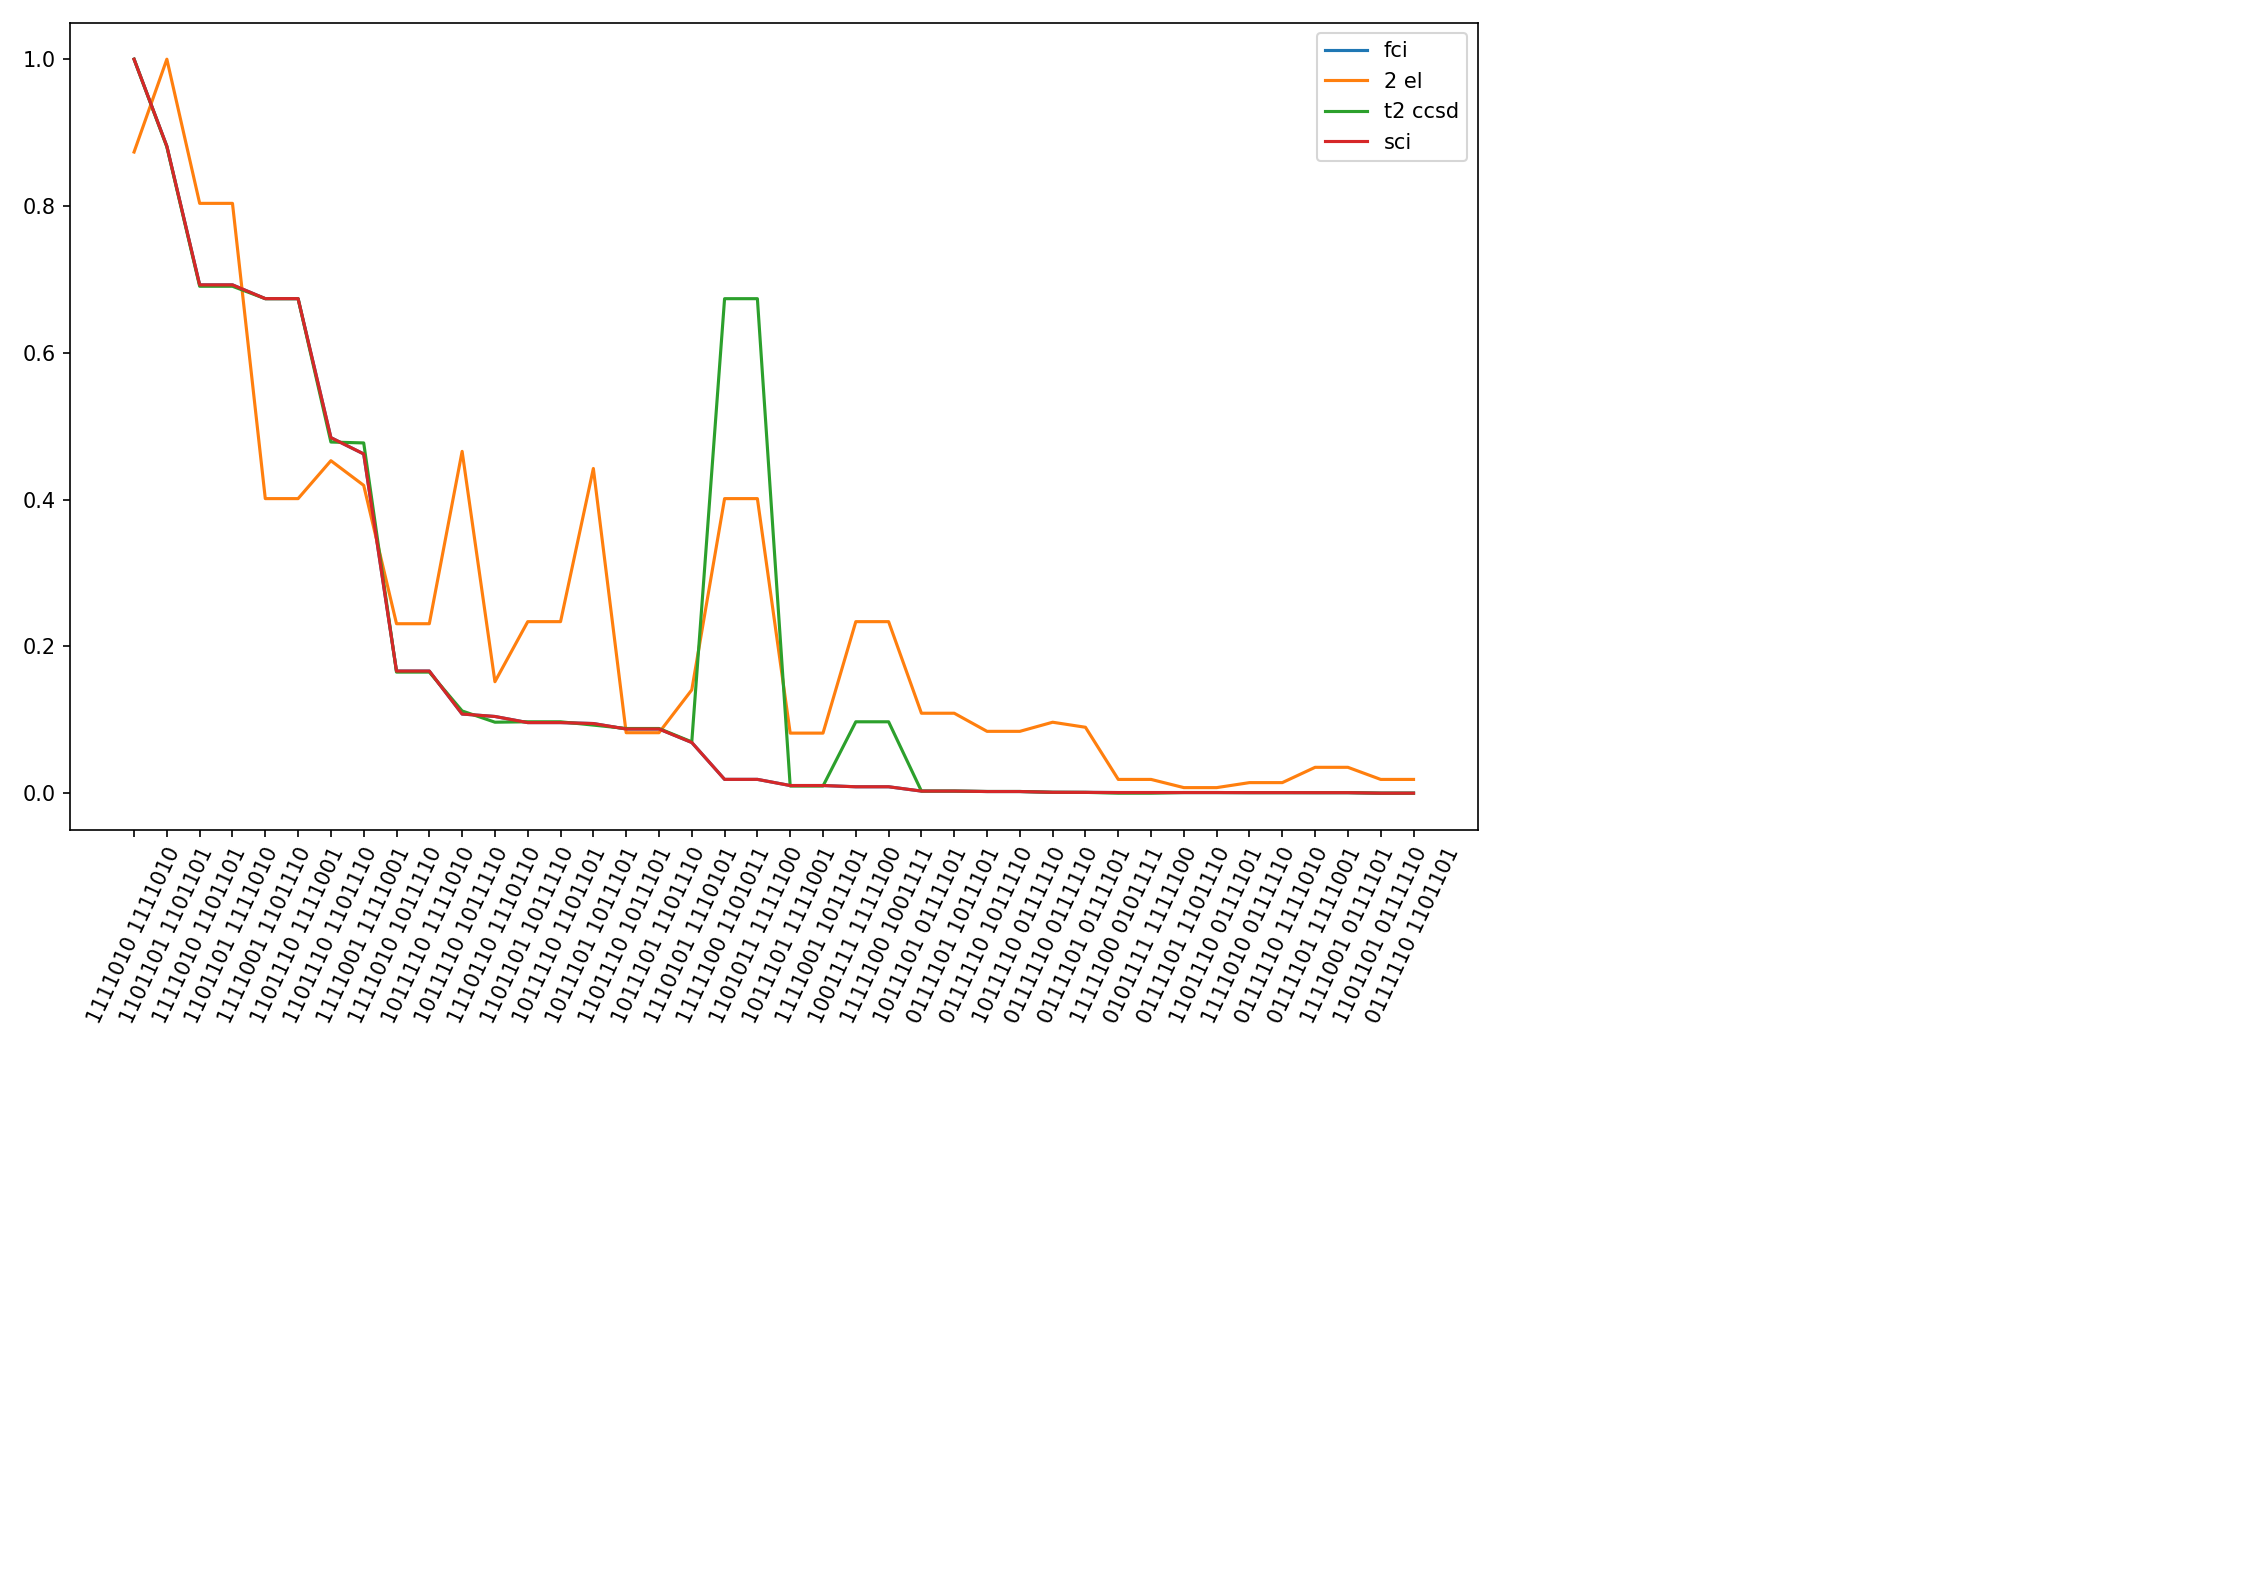

In [75]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(x, np.abs(np.asarray(fci_list))/np.amax(np.abs(np.asarray(fci_list))) , label='fci')
plt.plot(x, np.abs(np.asarray(two_el))/np.amax(np.abs(np.asarray(two_el))), label='2 el')
plt.plot(x, np.abs(np.asarray(t2_amp_list))/np.amax(np.abs(np.asarray(t2_amp_list))), label='t2 ccsd')
# plt.plot(x, np.abs(two_el_t)/np.amax(np.abs(two_el_t)), label='2 el t')
plt.plot(x, np.abs(np.asarray(sci_list))/np.amax(np.abs(np.asarray(sci_list))) , label='sci')
plt.legend()
plt.xticks(x, keys, rotation=65)
plt.tight_layout()

<IPython.core.display.Javascript object>


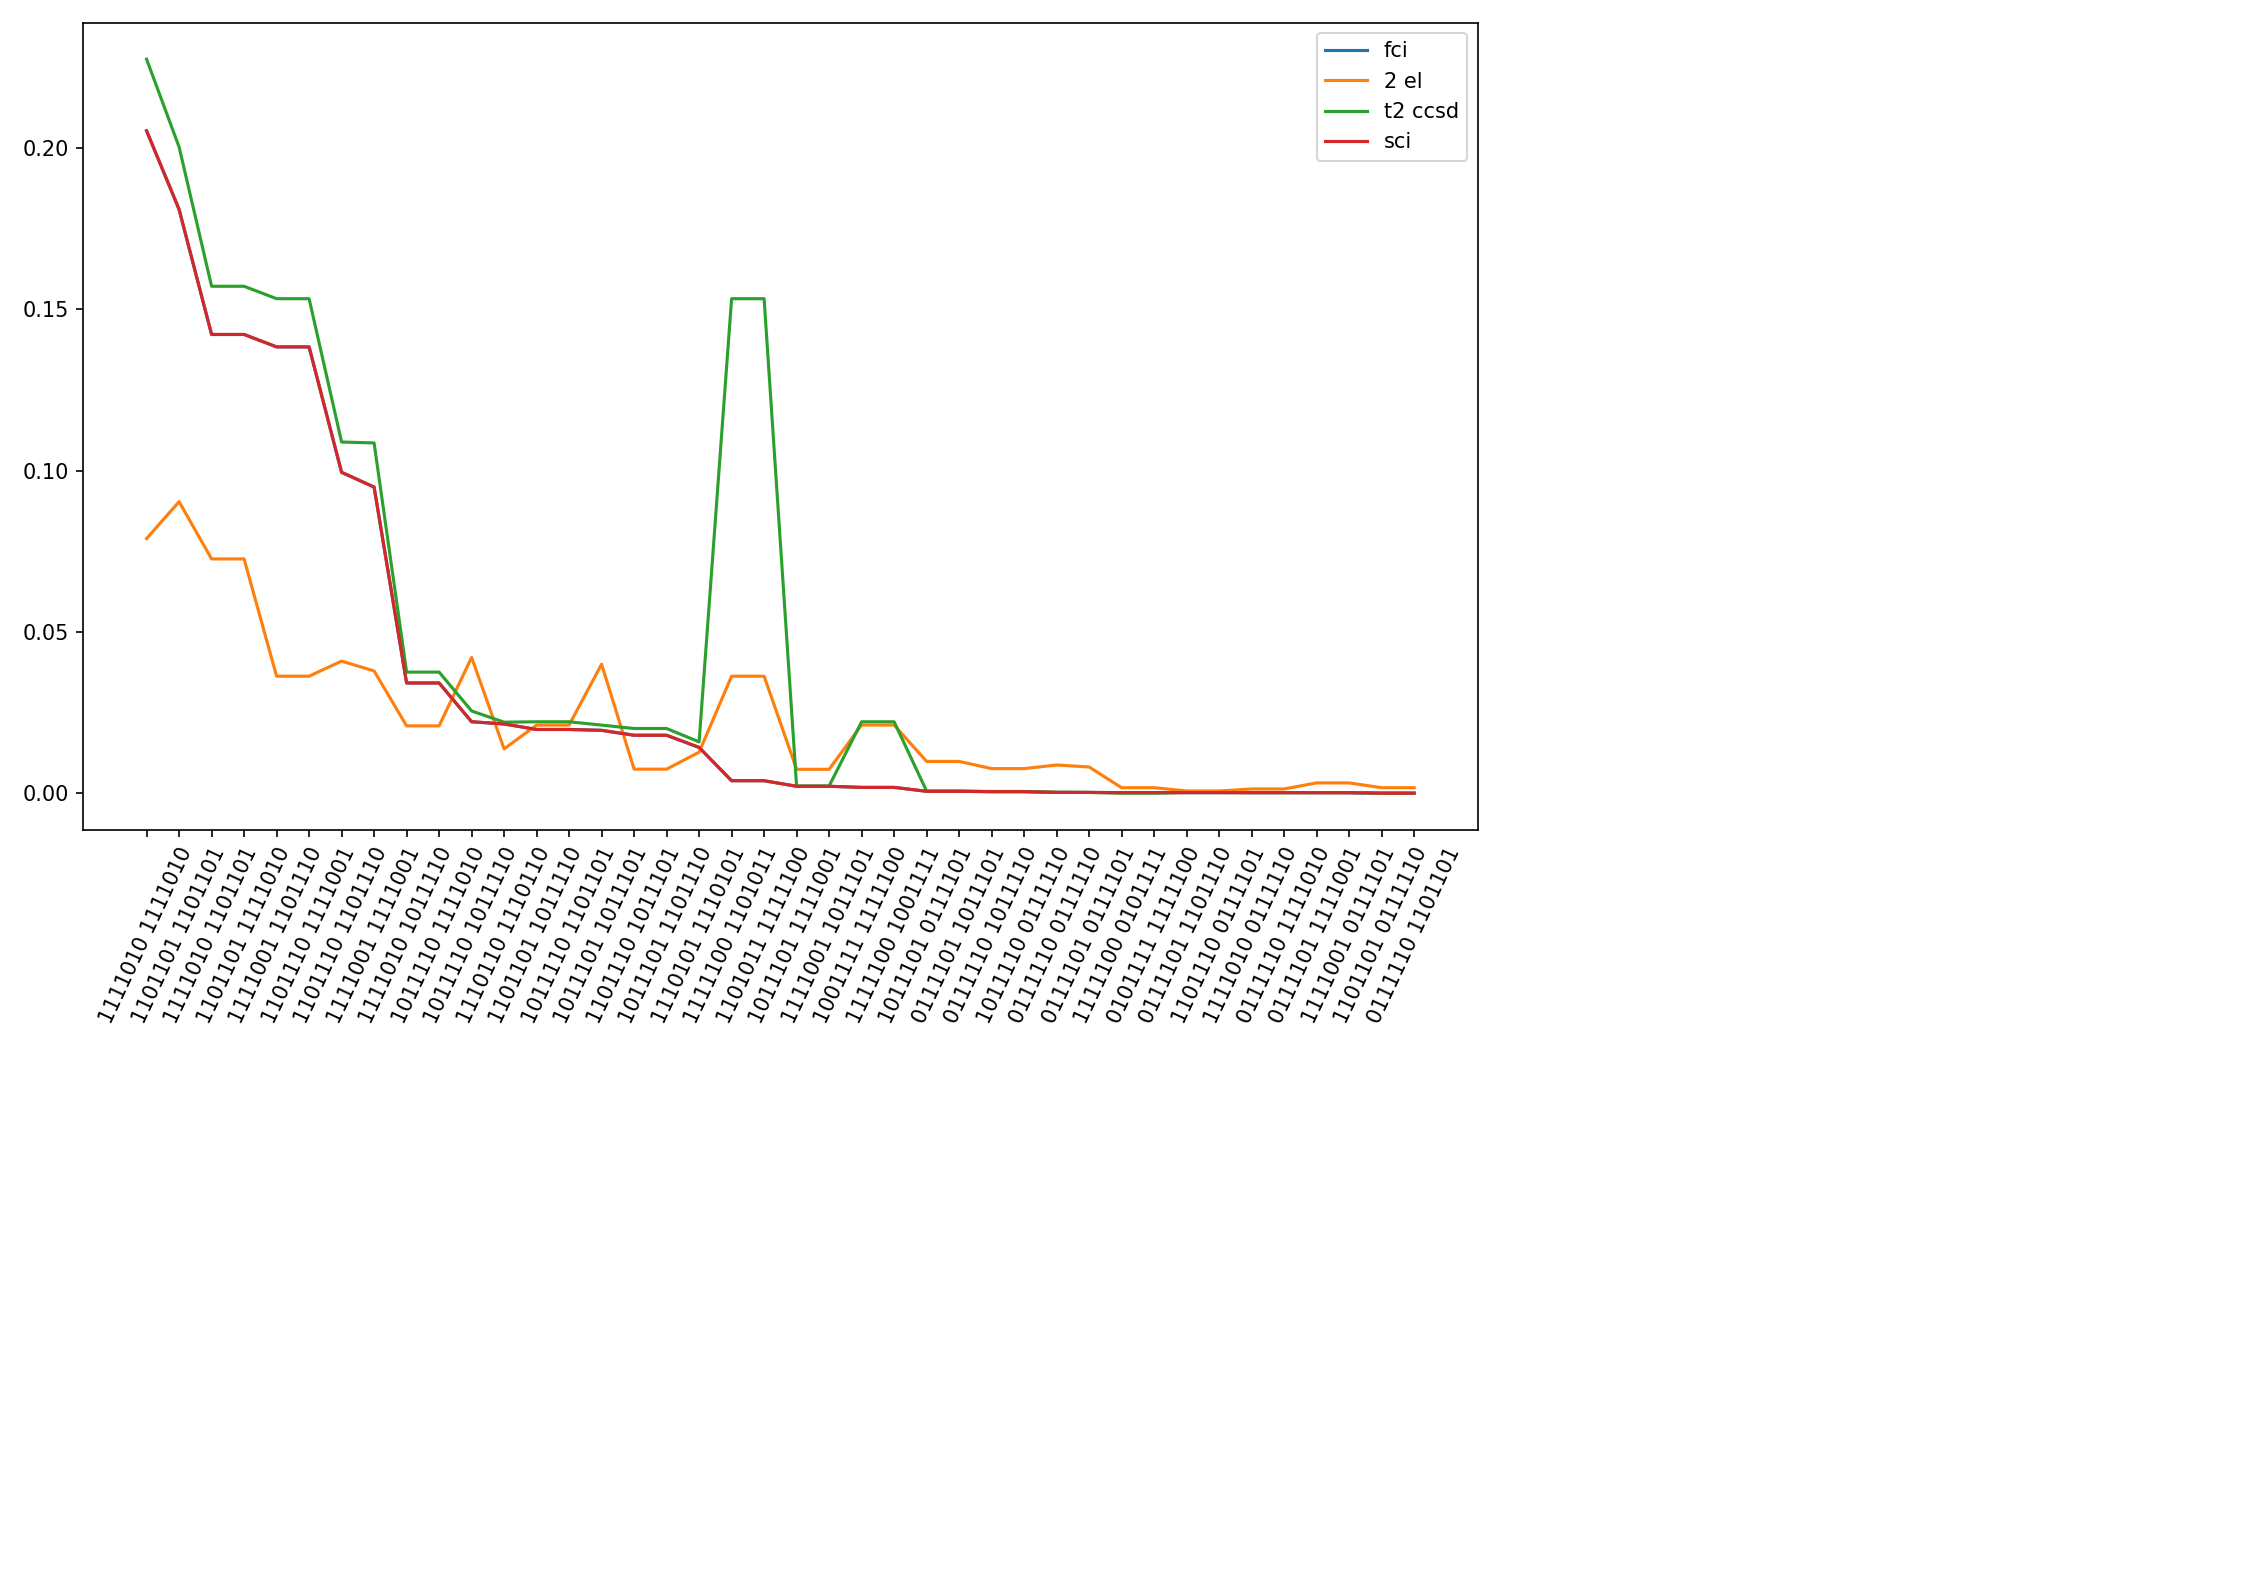

In [76]:
%matplotlib notebook

plt.rcParams["figure.figsize"] = (10,7)
plt.plot(x, np.abs(np.asarray(fci_list)) , label='fci')
plt.plot(x, np.abs(np.asarray(two_el)), label='2 el')
plt.plot(x, np.abs(np.asarray(t2_amp_list)), label='t2 ccsd')
# plt.plot(x, np.abs(two_el_t)/np.amax(np.abs(two_el_t)), label='2 el t')
plt.plot(x, np.abs(np.asarray(sci_list)) , label='sci')
plt.legend()
plt.xticks(x, keys, rotation=65)
plt.tight_layout()

# Triples

In [83]:
# Generating triples from singles
fci_triples_dict = filter_out_n_order_exc_dets(det_dict_spin_orb, 3)
ci_thresh_3 = ci_thresh
amp_thresh_3 = amp_thresh
amp_thresh_3 = 2e-2

filtered_fci_triples_dict = filter_dets_from_dict(fci_triples_dict, thresh=ci_thresh_3)

sci_triples_dict = filter_out_n_order_exc_dets(filtered_sci_dets_spin_orb, 3)

t3_configs = set()
contrib_coeff_dict_2e = dict()
unfiltered_contrib_coeff_dict_2e_t = dict()
contrib_coeff_dict_2e_t = dict()
unfiltered_contrib_coeff_dict_2e = dict()
for ini_conf in t1_configs:
#     print("Indices for initial conf", ini_conf, t1_amp_vs_det_dict[ini_conf])
    occ = [int(occ_str) for occ_str in ini_conf]
    t3_inds, t3_amp_vs_det_dict, _ = generate_t2_indices(norb_spatial, nelec, occ=occ)
    # making sure we only have triple excitations there
    filtered_t3_amp_vs_det_dict = filter_out_n_order_exc_dets(t3_amp_vs_det_dict, 3)
    for key in filtered_t3_amp_vs_det_dict.keys():
        configs.add(key)
        cur_ind = t3_amp_vs_det_dict[key]
#         print(cur_ind)
        h1_h2 = h1[t1_amp_vs_det_dict[ini_conf][0], t1_amp_vs_det_dict[ini_conf][1]]\
              * h2[cur_ind[3], cur_ind[1], cur_ind[0], cur_ind[2]] 
        unfiltered_contrib_coeff_dict_2e_t[key] = h1_h2 * amp_dict_t1[ini_conf]
        # try multiplying this by the amplitude corresponding to starting configuration
#         if np.abs(h1_h2 * amp_dict_t1[ini_conf]) > amp_thresh:
        if np.abs(h1_h2) > amp_thresh_3:
            if key in t3_configs:
#                 print(t1_amp_vs_det_dict[ini_conf], cur_ind, "is already in configs with amp", contrib_coeff_dict_2e_t[key], "new:", h1_h2)
                if np.abs(h1_h2) > np.abs(contrib_coeff_dict_2e_t[key]):
                    contrib_coeff_dict_2e_t[key] = h1_h2 #* amp_dict_t1[ini_conf]
                else:
                    pass
#                 print("Replaced with", contrib_coeff_dict_2e_t[key])
#             print(t1_amp_vs_det_dict[ini_conf][0], t1_amp_vs_det_dict[ini_conf][1], cur_ind)
            else:
                contrib_coeff_dict_2e_t[key] = h1_h2 
            t3_configs.add(key)
        unfiltered_contrib_coeff_dict_2e[key] = h1_h2
        if np.abs(h1_h2) > amp_thresh_3:
#             if key in t3_configs:
#                 print(key, "is already in configs with amp", contrib_coeff_dict_2e[key], "new:", h1_h2)
            contrib_coeff_dict_2e[key] = h1_h2
            
print("Significant t3 configs", len(t3_configs))
print("Number of triples in FCI:", len(fci_triples_dict.keys()))
print("Number of significant triples in FCI:", len(filtered_fci_triples_dict.keys()))

intersecting_set = set(sci_triples_dict.keys()).intersection(t3_configs)
difference_set = set(sci_triples_dict.keys()).symmetric_difference(intersecting_set)

fci_intersecting_set = set(filtered_fci_triples_dict.keys()).intersection(t3_configs)
fci_difference_set = set(filtered_fci_triples_dict.keys()).symmetric_difference(intersecting_set)
print("Matching significant configurations with FCI:", len(fci_intersecting_set))
print("\nNumber of triples in SCI:", len(sci_triples_dict.keys()))
print("Matching significant configurations with SCI", len(intersecting_set))

Significant t3 configs 22
Number of triples in FCI: 200
Number of significant triples in FCI: 46
Matching significant configurations with FCI: 22

Number of triples in SCI: 56
Matching significant configurations with SCI 22


In [85]:
# Generating triples from doubles
for ini_conf in t2_configs:
#     print("Indices for initial conf", t1_amp_vs_det_dict[ini_conf])
    occ = [int(occ_str) for occ_str in ini_conf]

    t3_inds_2, t3_amp_vs_det_dict_2, t3_amp_dict_2 = generate_t1_indices(norb_spatial, nelec, occ=occ)
    filtered_t3_amp_vs_det_dict_2 = filter_out_n_order_exc_dets(t3_amp_vs_det_dict_2, 3)
    for key in filtered_t3_amp_vs_det_dict_2.keys():
#         print(key, h2_h1 * amp_dict_t2[ini_conf])
        configs.add(key)
        cur_ind = t3_amp_vs_det_dict_2[key]

        h2_h1 = h1[cur_ind[0], cur_ind[1]]\
              * h2[t2_amp_vs_det_dict[ini_conf][3], t2_amp_vs_det_dict[ini_conf][1],
                   t2_amp_vs_det_dict[ini_conf][0], t2_amp_vs_det_dict[ini_conf][2]]
        if np.abs(h2_h1) > amp_thresh_3:
            if key in t3_configs:
#                 print(key, "is already in configs with amp", contrib_coeff_dict_2e_t[key], 
#                       "new:", h2_h1)
                if np.abs(h2_h1 ) > np.abs(contrib_coeff_dict_2e_t[key]):
                    contrib_coeff_dict_2e_t[key] = h2_h1 
#                     print("replaced with new", h2_h1)
                else: 
#                     print("Kept old", contrib_coeff_dict_2e_t[key])
                    pass
            
            else:
                t3_configs.add(key)
                contrib_coeff_dict_2e_t[key] = h2_h1 
#                 print(contrib_coeff_dict_2e_t[key])

#                 print("adding t3 config", key)
#                 print(key[0:norb_spatial], key[norb_spatial:], #cur_ind, 
#                   h1_h2, fci_triples_dict[key][0])
print("Significant t3 configs", len(t3_configs))
print("Number of triples in FCI:", len(fci_triples_dict.keys()))

intersecting_set = set(sci_triples_dict.keys()).intersection(t3_configs)
difference_set = set(sci_triples_dict.keys()).symmetric_difference(intersecting_set)


print("\nNumber of triples in SCI:", len(sci_triples_dict.keys()))
print("Matching significant configurations with SCI", len(intersecting_set))


Significant t3 configs 22
Number of triples in FCI: 200

Number of triples in SCI: 56
Matching significant configurations with SCI 22


In [86]:
n = len(t3_configs)
sorted_2e_dict = dict( sorted(contrib_coeff_dict_2e.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
sorted_2e_t_dict = dict( sorted(contrib_coeff_dict_2e_t.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
sorted_fci_dict = dict( sorted(fci_triples_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
sorted_sci_dict = dict( sorted(sci_triples_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))
sorted_filtered_fci_triples_dict = dict( sorted(filtered_fci_triples_dict.items(), key=lambda kv: np.abs(kv[1]), reverse=True))

set_2e_t = set(list(sorted_2e_t_dict.keys())[0:n])
set_2e = set(list(sorted_2e_dict.keys())[0:n])
set_fci = set(list(sorted_fci_dict.keys())[0:n])
set_sci = set(list(sorted_sci_dict.keys())[0:n])

print(len(set_2e_t.intersection(set_2e)))
print(len(set_2e_t.intersection(set_sci)), len(set_2e_t.intersection(set_fci)))
print(len(set_2e.intersection(set_sci)), len(set_2e.intersection(set_fci)))
triples_not_generated = set_2e_t.symmetric_difference(set_sci)

print("Missing triples:")
for conf in triples_not_generated:
    print(conf[:norb_spatial], conf[norb_spatial:])#, unfiltered_contrib_coeff_dict_2e[conf], unfiltered_contrib_coeff_dict_2e_t)
keys = []
fci_list = []
sci_list = []
two_el = []
two_el_t = []
n = 0
x = []
print("\n")
for key in sorted_filtered_fci_triples_dict.keys():
    print(key[:norb_spatial], key[norb_spatial:], #sorted_filtered_fci_triples_dict[key],
          sorted_sci_dict[key],
          contrib_coeff_dict_2e[key],
          contrib_coeff_dict_2e_t[key])
    keys.append(key[:norb_spatial] + " " + key[norb_spatial:])
    fci_list.append(sorted_fci_dict[key])
    sci_list.append(sorted_sci_dict[key])
    two_el.append(contrib_coeff_dict_2e[key])
    two_el_t.append(contrib_coeff_dict_2e_t[key])
    x.append(n)
    n += 1

22
22 22
22 22
Missing triples:


1101011 1101101 0.012279135143005099 0.16021485514474662 0.16021485514474662
1101101 1101011 0.012279135143005035 0.16021485514474662 0.16021485514474662
1101101 1001111 0.004026146245203586 -0.06887601132389679 -0.06887601132389679
1001111 1101101 0.004026146245203555 -0.04096416497293756 -0.06887601132389679
1011011 1101110 0.0033403553829398696 -0.02764070485284083 -0.02764070485284083
1101110 1011011 0.0033403553829398427 -0.027640704852840838 -0.027640704852840838
1110110 1100111 -0.003293530766746019 0.02661883864683777 0.02661883864683777
1100111 1110110 -0.0032935307667459938 0.02661883864683777 0.02661883864683777
1011011 1111001 0.0026793328567582607 -0.028884217348715227 -0.028884217348715227
1111001 1011011 0.0026793328567581488 -0.028884217348715227 -0.028884217348715227
1101011 1011110 0.002493225872042314 -0.027640704852840838 -0.040469591560256174
1011110 1101011 0.002493225872042318 -0.03743939761198269 -0.040469591560256216
1011101 10

KeyError: '10101111110101'

<IPython.core.display.Javascript object>


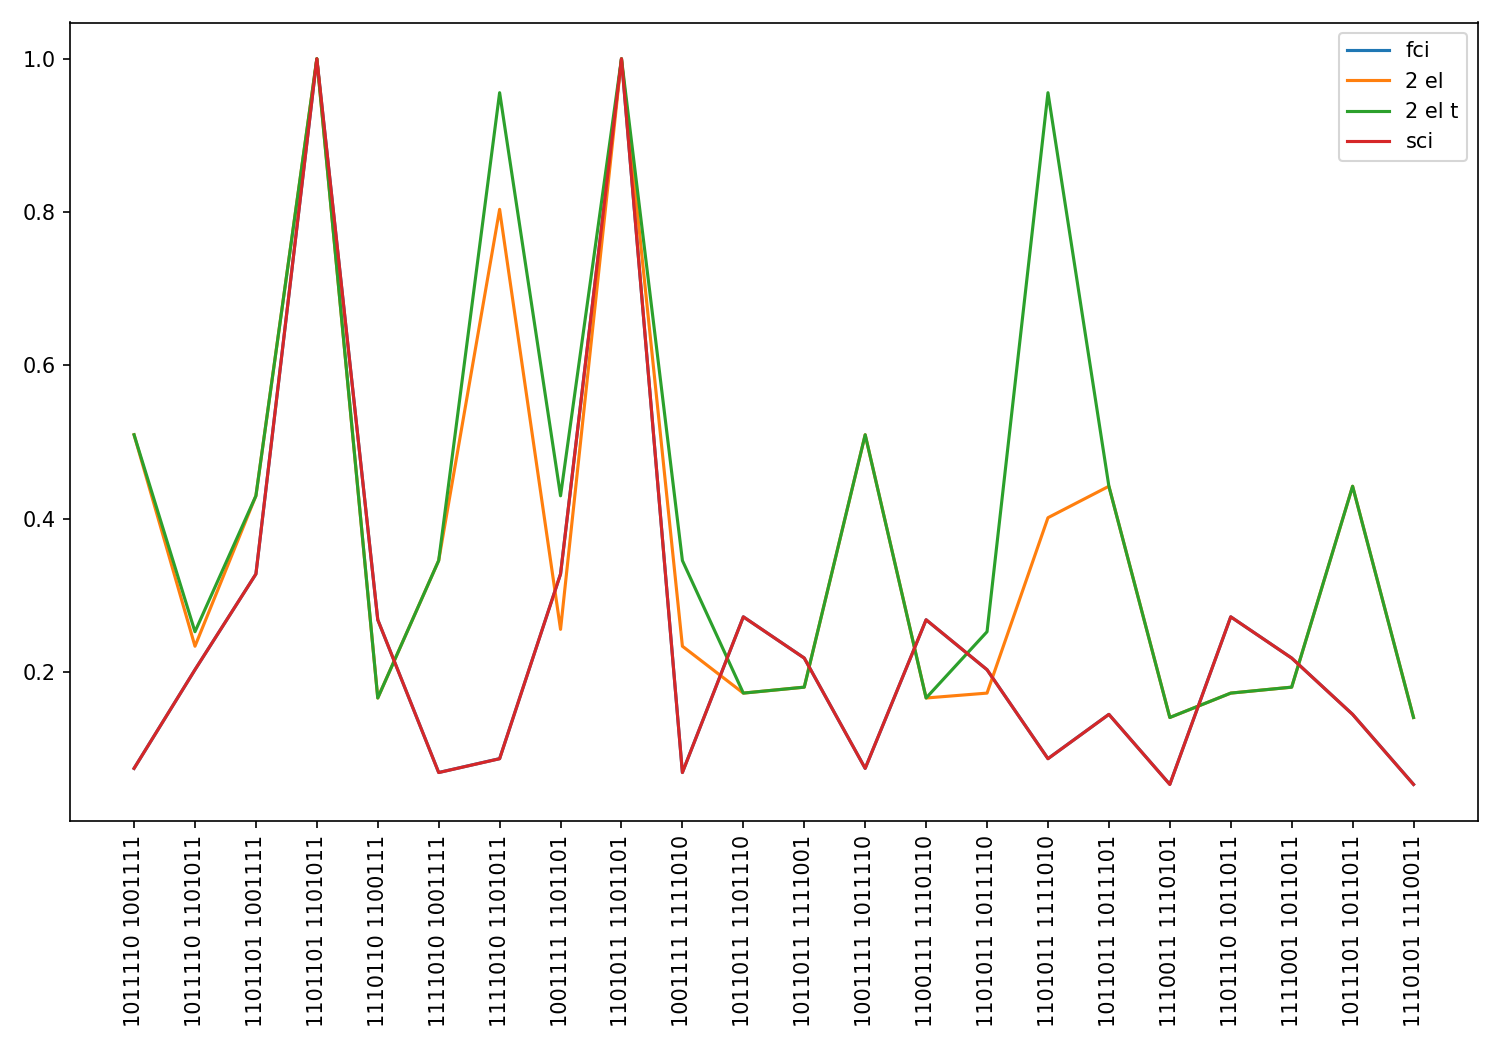

In [80]:
%matplotlib notebook

plt.plot(x, np.abs(np.asarray(fci_list))/np.amax(np.abs(np.asarray(fci_list))) , label='fci')
plt.plot(x, np.abs(np.asarray(two_el))/np.amax(np.abs(np.asarray(two_el))), label='2 el')
plt.plot(x, np.abs(two_el_t)/np.amax(np.abs(two_el_t)), label='2 el t')
plt.plot(x, np.abs(np.asarray(sci_list))/np.amax(np.abs(np.asarray(sci_list))) , label='sci')
plt.legend()
plt.xticks(x, keys, rotation='vertical')
plt.tight_layout()

# Quadruples

In [17]:
# Quadruples
q = 0
t4_configs = set()
ci_thresh_4 = ci_thresh
amp_thresh_4 = amp_thresh
amp_thresh_4 = 1e-3
fci_quad_dict = filter_out_n_order_exc_dets(det_dict_spin_orb, 4)
filtered_fci_quad_dict = filter_dets_from_dict(fci_quad_dict, thresh=ci_thresh_4)

sci_quad_dict = filter_out_n_order_exc_dets(filtered_sci_dets_spin_orb, 4)
filtered_sci_quad_dict = filter_dets_from_dict(sci_quad_dict, thresh=ci_thresh_4)

for ini_conf in t2_configs:
    occ = [int(occ_str) for occ_str in ini_conf]
#     print(occ)
#     print("Indices for initial conf", t2_amp_vs_det_dict[ini_conf])
    t4_inds, t4_amp_vs_det_dict, t4_amp_dict = generate_t2_indices(norb_spatial, nelec, occ=occ)
    filtered_t4_amp_vs_det_dict = filter_out_n_order_exc_dets(t4_amp_vs_det_dict, 4)
    for key in filtered_t4_amp_vs_det_dict.keys():
        configs.add(key)
        cur_ind = t4_amp_vs_det_dict[key]

        h2_h2 = h2[cur_ind[3], cur_ind[1], cur_ind[0], cur_ind[2]]\
              * h2[t2_amp_vs_det_dict[ini_conf][3], 
                   t2_amp_vs_det_dict[ini_conf][1],
                   t2_amp_vs_det_dict[ini_conf][0], 
                   t2_amp_vs_det_dict[ini_conf][2]]
        if np.abs(h2_h2) > amp_thresh_4:
            t4_configs.add(key)

print("Total number of significant quadruple configurations:", len(t4_configs))
            
print("\nNumber of quadruples in FCI:", len(fci_quad_dict.keys()))
print("Number of significant quadruples in FCI:", len(filtered_fci_quad_dict.keys()))

difference_set = set(sci_quad_dict.keys()).symmetric_difference(intersecting_set)
intersecting_set = set(sci_quad_dict.keys()).intersection(t4_configs)

fci_intersecting_set = set(filtered_fci_quad_dict.keys()).intersection(t4_configs)
fci_difference_set = set(filtered_fci_quad_dict.keys()).symmetric_difference(fci_intersecting_set)
print("Matching significant configurations with FCI", len(fci_intersecting_set))

print("\nNumber of quadruples in SCI:", len(sci_quad_dict.keys()))
print("Matching significant configurations with SCI", len(intersecting_set))
# print("Configurations that don't match:", difference_set)
 
# for key in difference_set:
#     print(key[0:norb_spatial], key[norb_spatial:], t4_amp_vs_det_dict[key])

Total number of significant quadruple configurations: 7

Number of quadruples in FCI: 100
Number of significant quadruples in FCI: 7
Matching significant configurations with FCI 7

Number of quadruples in SCI: 28
Matching significant configurations with SCI 7


In [ ]:
fci_set = set()
fci_set = set.union((set(list(fci_singles_dict.keys()))), fci_set)
fci_set = set.union((set(list(fci_doubles_dict.keys()))), fci_set)
fci_set = set.union((set(list(fci_triples_dict.keys()))), fci_set)
fci_set = set.union((set(list(fci_quad_dict.keys()))), fci_set)          

print("Number of FCI configs up to 4 order", len(fci_set))
print("Number of configs up to 4 order", len(configs))
print("Difference of FCI dict with generated by 2e dict:", len(fci_set.symmetric_difference(configs)))
print("Quadruples FCI intersection with generated by 2e:", len(set(fci_quad_dict.keys()).intersection(t4_configs)))

In [ ]:
print("Number of excitations in SCI of different order (not 1,2,3 or 4):", len(filtered_sci_dets_spin_orb) - len(sci_quad_dict.keys()) - len(sci_singles_dict) -
     len(sci_doubles_dict) - len(sci_triples_dict))
print()


In [ ]:
for n in range(1, 7):
    print("n=", n)
    print(len(filter_out_n_order_exc_dets(filtered_sci_dets_spin_orb, n)))

In [ ]:
filtered_t2 = []
filtered_t2_amps = []
for t2 in t2_inds:
    if np.abs(h2[t2[3], t2[1], t2[0], t2[2]]) > thresh:
        filtered_t2.append(t2)
        filtered_t2_amps.append(h2[t2[3], t2[1], t2[0], t2[2]])
        sorted_filtered_t2 = sorted(zip(filtered_t2, filtered_t2_amps), key=lambda kv: np.abs(kv[1]), reverse=True)
print("Number of t2 amplitudes filtered by 2e integrals amplitudes", len(filtered_t2))
print("Number of t2 amplitudes filtered by SCI", len(t2_sci_filtered))
print("Number of t2 amplitudes filtered by MP2", len(t2_mp2_filtered))


# Printing 2e integrals values for matching indices with amps filtered by SCI
print("\nMatching with SCI")
n_matches_with_SCI_sel = 0
for ind_2e_int_sel in t2_inds: # selected by 2e integrals
    for ind_sci_sel in t2_sci_filtered: # selected by SCI
        if ind_2e_int_sel == ind_sci_sel:
            n_matches_with_SCI_sel += 1
#             print(ind_2e_int_sel, h2[ind_2e_int_sel[3], ind_2e_int_sel[1], ind_2e_int_sel[0], ind_2e_int_sel[2]])
print("Number of matches of 2e filtering with SCI filtering is {}".format(n_matches_with_SCI_sel))


# Printing 2e integrals values for matching indices with amps filtered by MP2
print("\nMatching with MP2")
n_matches_with_mp2_sel = 0
for ind_2e_int_sel in filtered_t2: # selected by 2e integrals
    for ind_mp2_sel in t2_mp2_filtered: # selected by SCI
        if ind_2e_int_sel == ind_mp2_sel:
            n_matches_with_mp2_sel += 1
#             print(ind_2e_int_sel, h2[ind_2e_int_sel[3], ind_2e_int_sel[1], ind_2e_int_sel[0], ind_2e_int_sel[2]])
print("Number of matches of 2e filtering with MP2 filtering is {}".format(n_matches_with_mp2_sel))

In [ ]:
alpha, beta, coeff = create_array_for_heatmap(det_dict_spin_orb)
det_to_num_dict = dict()
alpha_set = set()
beta_set = set()
for x in alpha:
    alpha_set.add(x)
for y in beta:
    beta_set.add(y)

print(len(alpha_set.intersection(beta_set)), len(alpha_set), len(beta_set))

for ind, x in enumerate(alpha_set):
    det_to_num_dict[x] = ind
# print(det_to_num_dict)

# initialize list of lists
data = []
for alpha in alpha_set:
        data.append([det_dict_spin_orb[alpha + beta] for beta in beta_set])
# data = [det_dict_spin_orb[alpha_set + beta] for beta in alpha_set]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = list(alpha_set))
df.index = list(alpha_set)
# print(df)
# sns.heatmap(df)

# Running UCCSD

In [ ]:
fer_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)

In [ ]:
ee = NumPyMinimumEigensolver(qubit_op)
result = core.process_algorithm_result(ee.run())
exact_e = result['computed_electronic_energy']
print("exact_e", exact_e)

In [ ]:
init_state = HartreeFock(num_orbitals=core._molecule_info['num_orbitals'],
                    qubit_mapping=core._qubit_mapping, two_qubit_reduction=core._two_qubit_reduction,
                    num_particles=core._molecule_info['num_particles'])

In [ ]:
var_form = UCCSD(num_orbitals=core._molecule_info['num_orbitals'],
                   num_particles=core._molecule_info['num_particles'],
                   active_occupied=None, active_unoccupied=None, initial_state=init_state,
                   qubit_mapping=core._qubit_mapping, two_qubit_reduction=core._two_qubit_reduction,
                   num_time_slices=1,
                   single_exc_op_list=[[1, 2], [7, 8], [0, 2], [6, 8], [1, 5], [7, 11], [0, 5], [6, 11]],
                   double_exc_op_list=[[0, 2, 7, 11], [0, 5, 7, 8], [1, 2, 6, 11], [1, 5, 6, 8], [1, 2, 7, 8], [0, 2, 7, 8], [1, 2, 6, 8],
                   [1, 2, 7, 11], [1, 5, 7, 8], [0, 2, 6, 8], [0, 2, 6, 11], [0, 5, 6, 8], [1, 3, 7, 9], [0, 3, 7, 9], 
                   [1, 3, 6, 9], [0, 3, 6, 9], [1, 4, 7, 10], [0, 4, 7, 10], [1, 4, 6, 10], [0, 4, 6, 10], [1, 5, 7, 11], [0, 5, 7, 11], [1, 5, 6, 11], [0, 5, 6, 11]],
                   triple_exc_op_list=[[0, 2, 7, 8, 7, 11], [0, 2, 7, 11, 7, 8], [0, 5, 7, 8, 7, 8], [1, 2, 6, 8, 7, 11], [1, 2, 6, 11, 7, 8], [1, 5, 6, 8, 7, 8]],
                )

vqe = VQE(qubit_op,  var_form=var_form, initial_point=None) # particle number and S^2 expectation values


In [ ]:
print(len(var_form._triple_excitations), len(var_form._double_excitations), len(var_form._single_excitations))
# print(var_form._hopping_ops)
# for op in var_form._hopping_ops:
#     print(op)
n=35
# print(var_form._hopping_ops[n].evolve().decompose())
print(len(var_form._hopping_ops[n]._paulis))

In [ ]:
backend_type = 'statevector_simulator'
backend = Aer.get_backend(backend_type)
quantum_instance = QuantumInstance(backend=backend, shots=10000)
ret = vqe.run(quantum_instance)
# print('computed e', ret['optimal_value'])
# print("\nResults:")
# print(ret)

In [ ]:
n = 10
print(qubit_op.paulis[n][1])
print(qubit_op.paulis[n][0])
print(qubit_op.paulis[n][1].z)
print(qubit_op.paulis[n][1].x)
print(qubit_op.paulis[n][1].phase)